# 2D Percolation Simulation and Analysis

This project presents a computational study of 2D site percolation on a square lattice, a fundamental model in statistical physics for understanding phase transitions and connectivity.

Using Monte Carlo methods with Python, NumPy, and SciPy, this analysis covers three core aspects of the percolation model:
1.  **Visualization:** Demonstrating the qualitative difference between the subcritical, critical, and supercritical phases.
2.  **Susceptibility Analysis:** Quantitatively identifying the critical probability threshold `p_c` by finding the peak of the mean finite cluster size (susceptibility) for various system sizes.
3.  **Fractal Dimension:** Calculating the fractal dimension `D_f` of the spanning cluster at `p_c` using the box-counting method, confirming its non-integer dimensionality.

The simulations are optimized for performance using `scipy.ndimage` for cluster labeling and `multiprocessing` to run statistical analyses in parallel across multiple CPU cores. The final calculated values for `p_c` and `D_f` are shown to be in good agreement with their known theoretical values.

In [ ]:
# !pip install imageio
# !pip install scipy

## Part 1: Visualizing the Percolation Transition

Percolation theory is a model used to describe connectivity in random systems. We imagine a square lattice where each site can be either "occupied" or "empty," determined by an occupation probability `p`.

When `p` is low, occupied sites form small, isolated clusters. As `p` increases, these clusters grow and merge. At a specific **critical probability**, `p_c`, a giant cluster suddenly forms that spans the entire lattice. This is a phase transition.

In this first section, we will visually demonstrate this transition by generating and plotting lattices for three key probabilities:
1.  **p < p_c** (Subcritical)
2.  **p ≈ p_c** (Critical)
3.  **p > p_c** (Supercritical)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from scipy.ndimage import label
from collections import deque

# --- Core Simulation Functions ---

def generate_lattice(L, p):
    """Generates an L x L lattice with occupation probability p."""
    return np.random.rand(L, L) < p

def plot_lattice(grid, cluster_grid=None, ax=None):
    """
    Visualizes the percolation lattice and highlights a specific cluster.
    'cluster_grid' is expected to be a boolean numpy array of the same size as grid.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    L = grid.shape[0]
    img = np.zeros((L, L, 3), dtype=np.uint8)
    
    # Set all occupied sites to white
    img[grid == 1] = [255, 255, 255]
    
    # Check if a cluster grid was provided (it won't be None)
    if cluster_grid is not None:
        # Use boolean indexing to set all cluster sites to red.
        img[cluster_grid] = [255, 0, 0]

    ax.imshow(img, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

def create_evolving_gif(L=100, num_frames=50, filename="percolation_evolving.gif"):
    """
    Generates a GIF showing a single lattice evolving as p increases,
    and displays the size of the largest cluster on each frame.
    """
    print("Generating frames for an evolving GIF...")
    random_grid = np.random.rand(L, L)
    frames_dir = "evolving_frames"
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir)
    filenames = []
    p_values = np.linspace(0.45, 0.7, num_frames)

    for i, p in enumerate(p_values):
        lattice = random_grid < p
        labeled_grid, num_clusters = label(lattice)
        
        max_size = 0
        if num_clusters > 0:
            # np.bincount counts occurrences of each label. Label 0 is the background.
            cluster_sizes = np.bincount(labeled_grid.ravel())
            # Find the largest size, ignoring the background cluster (label 0)
            if len(cluster_sizes) > 1:
                max_size = np.max(cluster_sizes[1:])

        fig, ax = plt.subplots(figsize=(5, 5))
        
        # We can highlight the largest cluster
        largest_cluster_grid = None
        if max_size > 0:
            largest_cluster_label = np.argmax(cluster_sizes[1:]) + 1
            largest_cluster_grid = (labeled_grid == largest_cluster_label)
        
        plot_lattice(lattice, largest_cluster_grid, ax=ax)
        
        # Update the title with the new information
        ax.set_title(f'p = {p:.3f}\nLargest Cluster: {max_size} cells')
        
        frame_filename = f"{frames_dir}/frame_{i:03d}.png"
        filenames.append(frame_filename)
        plt.savefig(frame_filename)
        plt.close(fig)

    print(f"Compiling frames into {filename}...")
    with imageio.get_writer(filename, mode='I', duration=100, loop=0) as writer:
        for frame_filename in filenames:
            writer.append_data(imageio.imread(frame_filename))

    print("Cleaning up temporary frames...")
    for frame_filename in filenames:
        os.remove(frame_filename)
    os.rmdir(frames_dir)

    print(f"Success! Evolving GIF saved as {filename}")

def plot_critical_phases(L=150):
    """
    Generates and displays a plot showing the three distinct phases of percolation.
    """
    print("Plotting the three critical phases...")
    
    probabilities = [0.55, 0.5927, 0.65]
    titles = ['p = 0.55 (Subcritical)', 'p = 0.5927 (Critical)', 'p = 0.65 (Supercritical)']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, p in enumerate(probabilities):
        lattice = generate_lattice(L, p)
        labeled_grid, num_clusters = label(lattice)
        
        largest_cluster_grid = None
        if num_clusters > 0:
            # Find the largest cluster to highlight it
            cluster_sizes = np.bincount(labeled_grid.ravel())
            if len(cluster_sizes) > 1:
                largest_cluster_label = np.argmax(cluster_sizes[1:]) + 1
                largest_cluster_grid = (labeled_grid == largest_cluster_label)
        
        plot_lattice(lattice, largest_cluster_grid, ax=axes[i])
        axes[i].set_title(titles[i], fontsize=16)

    plt.tight_layout()
    plt.show()

Plotting the three critical phases...


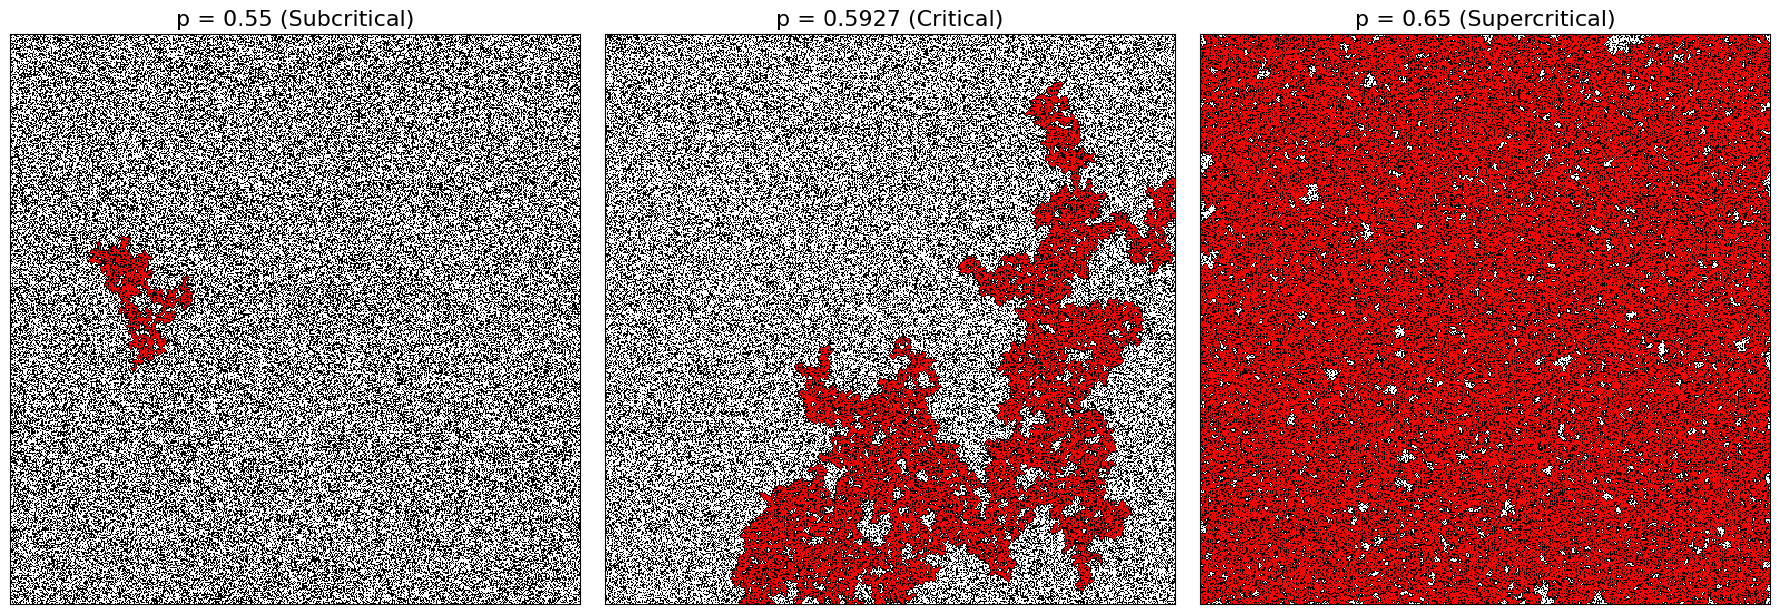

Generating frames for an evolving GIF...
Compiling frames into percolation_evolving.gif...


/tmp/ipykernel_123/2457709134.py:83: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame_filename))


Cleaning up temporary frames...
Success! Evolving GIF saved as percolation_evolving.gif


In [2]:
if __name__ == "__main__":
    plot_critical_phases(L=512)
    create_evolving_gif(L=512, num_frames=360)

## Part 2: Finding the Critical Threshold via Susceptibility

While visual inspection gives us a good idea of `p_c`, a more precise method is to measure a physical quantity that is highly sensitive at the critical point. In percolation, this quantity is the **susceptibility**, `χ`, which represents the mean size of the *finite* clusters.

The susceptibility is defined as:
$$ \chi = \frac{\sum_{s}' s^2 n_s}{N} $$
where `s` is the cluster size, `n_s` is the number of clusters of size `s`, `N` is the total number of sites, and the sum `Σ'` is over all *finite* clusters (i.e., we exclude the single largest cluster).

We expect `χ` to show a sharp peak near `p_c`. As the lattice size `L` increases, this peak should become sharper and its location will give a more accurate estimate of the critical probability. By plotting `χ` vs. `p` for different lattice sizes, we can clearly visualize this sharpening effect.


In [3]:
from scipy.signal import savgol_filter
from multiprocessing import Pool, cpu_count
import time

def calculate_susceptibility(p, L):
    """
    Calculates the susceptibility for a single realization of an L x L grid.
    """
    # 1. Generate a random lattice
    grid = np.random.rand(L, L) < p
    
    # 2. Find all clusters using SciPy's highly optimized function
    labeled_grid, num_clusters = label(grid)
    
    # If there are no clusters, susceptibility is 0
    if num_clusters == 0:
        return 0
        
    # 3. Get the size of every cluster (label 0 is the background)
    cluster_sizes = np.bincount(labeled_grid.ravel())[1:]
    
    # 4. Identify the largest cluster
    largest_cluster_size = np.max(cluster_sizes)
    
    # 5. Calculate the sum of squares of all *finite* cluster sizes.
    # We do this by subtracting the square of the largest cluster's size
    # from the sum of squares of all cluster sizes.
    total_sum_sq = np.sum(cluster_sizes**2)
    finite_sum_sq = total_sum_sq - largest_cluster_size**2
    
    # 6. Return the susceptibility for this realization
    return finite_sum_sq / (L * L)


def get_avg_susceptibility(args):
    """
    Helper function to run multiple realizations for a single (p, L) pair
    and return the average susceptibility. Designed to be used with multiprocessing.
    """
    p, L, num_realizations = args
    
    # Run the simulation num_realizations times
    susceptibilities = [calculate_susceptibility(p, L) for _ in range(num_realizations)]
    
    # Return the average value and the probability it corresponds to
    return p, np.mean(susceptibilities)


def run_and_plot_susceptibility(L_values=[32, 64, 128, 256], min_p=0.55,max_p=0.65, resolution=51, num_realizations=200):
    # --- Simulation Parameters ---
    p_values = np.linspace(min_p, max_p, resolution)
    all_results = {}
    start_time = time.time()

    # --- Run Parallel Simulations ---
    for L in L_values:
        print(f"--- Running simulations for L = {L} ---")
        args_list = [(p, L, num_realizations) for p in p_values]
        with Pool(processes=cpu_count()) as pool:
            run_results = pool.map(get_avg_susceptibility, args_list)
        all_results[L] = np.array(run_results)

    end_time = time.time()
    print(f"--- All simulations finished in {end_time - start_time:.2f} seconds ---")

    # --- Plotting the Enhanced Results ---
    plt.figure(figsize=(14, 9))
    
    # Get the color cycle so raw data, smooth lines, and vertical lines match
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

    for i, L in enumerate(L_values):
        color = color_cycle[i % len(color_cycle)] # Assign a unique color for each L
        p_data = all_results[L][:, 0]
        chi_data = all_results[L][:, 1]
        
        # 1. Plot the raw data points with some transparency
        plt.plot(p_data, chi_data, 'o', color=color, alpha=0.3, label=f'_Raw Data L={L}')
        
        # 2. Plot the smoothed curve
        smooth_chi = savgol_filter(chi_data, window_length=11, polyorder=3)
        plt.plot(p_data, smooth_chi, '-', color=color, linewidth=2, label=f'L = {L}')
        
        # 3. Find and highlight the peak p-value for each lattice
        peak_p = p_data[np.argmax(smooth_chi)]
        plt.axvline(x=peak_p, color=color, linestyle='--', alpha=0.8, 
                    label=f'Peak for L={L} at p≈{peak_p:.4f}')

    plt.xlabel('Occupation Probability (p)', fontsize=14)
    plt.ylabel('Susceptibility (χ)', fontsize=14)
    plt.title('Susceptibility vs. Probability for Different Lattice Sizes', fontsize=16)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

--- Running simulations for L = 32 ---
--- Running simulations for L = 64 ---
--- Running simulations for L = 128 ---
--- Running simulations for L = 256 ---
--- All simulations finished in 237.40 seconds ---


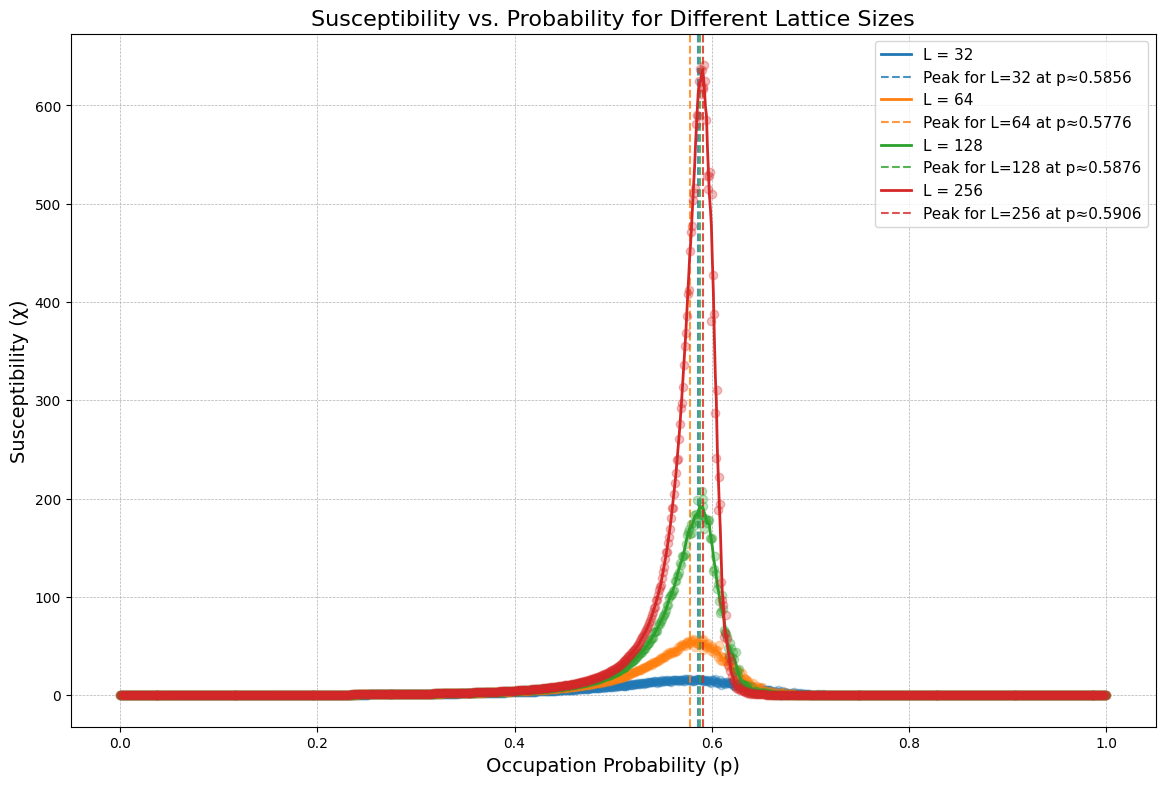

In [4]:
if __name__ == "__main__":
    run_and_plot_susceptibility(min_p=0, max_p=1, resolution=1000, num_realizations=200)

--- Running simulations for L = 32 ---
--- Running simulations for L = 64 ---
--- Running simulations for L = 128 ---
--- Running simulations for L = 256 ---
--- All simulations finished in 54.56 seconds ---


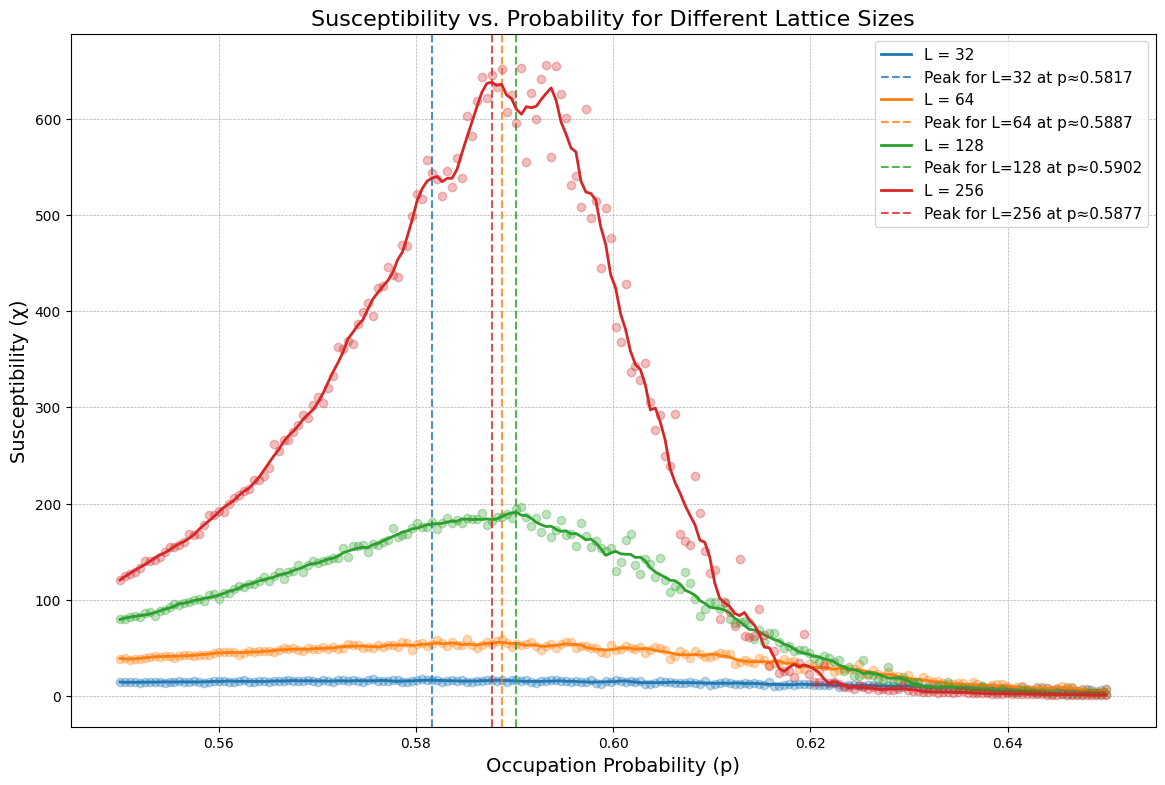

In [5]:
if __name__ == "__main__":
    run_and_plot_susceptibility(resolution=200)

## Part 3: Calculating the Fractal Dimension with Box-Counting

Now that we have a clear picture of the critical point `p_c`, the next step is to analyze the structure of the cluster that forms at this point. The large cluster at `p_c` is not a simple one- or two-dimensional object; it's a **fractal**. Its most important property is its **fractal dimension**, `D_f`.

To calculate this from our simulation, we will use the **box-counting method**. The number of boxes `N(b)` of size `b` needed to cover the cluster follows a power-law relationship:
$$N(b) \propto b^{-D_f}$$
By taking the logarithm of both sides, we get a linear relationship:
$$\log(N(b)) \propto -D_f \log(b)$$
To get a statistically robust result, we will run many realizations, average the box counts `<N(b)>` for each box size `b`, and then plot `log(<N(b)>)` versus `log(b)`. The slope of the resulting line will be `-D_f`, giving us our simulated fractal dimension. We will do this for several lattice sizes to see how the result depends on the system size.

In [6]:
def get_largest_cluster(L, p):
    """
    Generates a single lattice and finds the largest cluster in it.
    
    Returns:
        A numpy array of (row, col) coordinates for the largest cluster.
    """
    # Generate one lattice at the critical probability
    grid = generate_lattice(L, p)
    
    # Find all clusters using SciPy's label function
    labeled_grid, num_clusters = label(grid)
    
    # Return None if no clusters are found
    if num_clusters == 0:
        return None
        
    # Get the size of every cluster (label 0 is the background, so we ignore it)
    cluster_sizes = np.bincount(labeled_grid.ravel())[1:]
    
    # Find the label of the largest cluster
    # We add 1 because our sizes array is 0-indexed (we sliced off the background)
    largest_cluster_label = np.argmax(cluster_sizes) + 1
    
    # Get the coordinates of all sites with that label
    cluster_coords = np.column_stack(np.where(labeled_grid == largest_cluster_label))
    
    return cluster_coords


def box_counting_analysis(cluster_coords, box_sizes):
    """
    Performs the box-counting algorithm on a set of cluster coordinates.
    """
    counts = []
    
    # Get the min/max coordinates to define the bounding box of the cluster
    min_coords = np.min(cluster_coords, axis=0)
    max_coords = np.max(cluster_coords, axis=0)
    
    for b in box_sizes:
        # Normalize and scale coordinates to find which box each point belongs to
        scaled_coords = (cluster_coords - min_coords) // b
        
        # The number of unique rows in the scaled coordinate array is the number of occupied boxes
        num_occupied_boxes = len(np.unique(scaled_coords, axis=0))
        counts.append(num_occupied_boxes)
        
    return np.array(counts)


# --- The main analysis function ---
def run_fractal_dimension_analysis(L_values=[128, 256, 512, 1024], num_realizations=30, p_c=0.5927):
    """
    Calculates D_f by averaging box counts over many realizations first,
    then performs a single linear fit for each lattice size L.
    """
    final_results = {}
    start_time = time.time()

    print("--- Starting Fractal Dimension Analysis (Averaging Raw Data) ---")
    
    # --- Create a single figure for all log-log plots ---
    plt.figure(figsize=(10, 7))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, L in enumerate(L_values):
        print(f"\nRunning {num_realizations} realizations for L = {L}...")
        
        box_sizes = [2**j for j in range(1, int(np.log2(L))-1)]
        all_box_counts = []

        for k in range(num_realizations):
            print(f"  Realization {k+1}/{num_realizations}", end='\r')
            cluster_coords = get_largest_cluster(L, p_c)
            if cluster_coords is not None and len(cluster_coords) > 10:
                counts = box_counting_analysis(cluster_coords, box_sizes)
                all_box_counts.append(counts)
        
        print(f"\n  Finished collecting data for L = {L}.")
        if not all_box_counts:
            print(f"  No valid clusters found for L={L}. Skipping.")
            continue
            
        # Average the box counts and prepare for plotting
        avg_box_counts = np.mean(all_box_counts, axis=0)
        valid_indices = avg_box_counts > 0
        log_box_sizes = np.log(box_sizes)[valid_indices]
        log_counts = np.log(avg_box_counts)[valid_indices]

        if len(log_box_sizes) < 2:
            print(f"  Not enough data points for a fit for L={L}. Skipping.")
            continue
            
        # Perform linear fit and store the result
        coeffs = np.polyfit(log_box_sizes, log_counts, 1)
        fractal_dimension = -coeffs[0]
        final_results[L] = fractal_dimension
        
        # --- Add this L's data to the combined plot ---
        color = color_cycle[i % len(color_cycle)]
        plt.plot(log_box_sizes, log_counts, 'o', color=color, alpha=0.5)
        plt.plot(log_box_sizes, np.polyval(coeffs, log_box_sizes), '-', color=color,
                 label=f'L={L}, $D_f \\approx$ {fractal_dimension:.3f}')

    # --- Finalize the combined log-log plot ---
    plt.xlabel('log(box size, b)', fontsize=14)
    plt.ylabel('log(<Number of Boxes, N(b)>)', fontsize=14)
    plt.title('Box-Counting Analysis for Different Lattice Sizes', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    end_time = time.time()
    print(f"\n--- Analysis finished in {end_time - start_time:.2f} seconds ---")

    # --- Final Results Summary Table ---
    print("\n--- Results Summary ---")
    print("Theoretical D_f = 91/48 ≈ 1.896")
    print("-" * 40)
    print(f"{'Lattice Size (L)':<20} {'Fractal Dimension (D_f)':<20}")
    print("-" * 40)
    for L, Df in final_results.items():
        print(f"{L:<20} {Df:<20.4f}")
    print("-" * 40)



--- Starting Fractal Dimension Analysis (Averaging Raw Data) ---

Running 30 realizations for L = 128...
  Realization 30/30
  Finished collecting data for L = 128.

Running 30 realizations for L = 256...
  Realization 30/30
  Finished collecting data for L = 256.

Running 30 realizations for L = 512...
  Realization 30/30
  Finished collecting data for L = 512.

Running 30 realizations for L = 1024...
  Realization 30/30
  Finished collecting data for L = 1024.


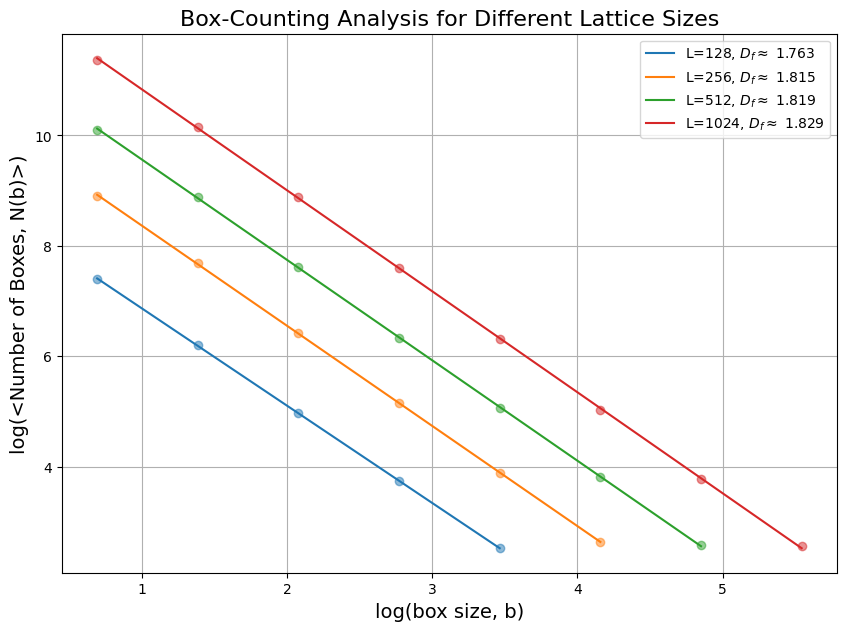


--- Analysis finished in 72.62 seconds ---

--- Results Summary ---
Theoretical D_f = 91/48 ≈ 1.896
----------------------------------------
Lattice Size (L)     Fractal Dimension (D_f)
----------------------------------------
128                  1.7629              
256                  1.8145              
512                  1.8190              
1024                 1.8294              
----------------------------------------


In [7]:
# This guard is important, especially if you ever adapt this for multiprocessing
if __name__ == "__main__":
    run_fractal_dimension_analysis()

## Conclusion

This project successfully simulated 2D site percolation and analyzed its critical properties.

- We visually observed the phase transition from a disconnected to a connected state and used the **susceptibility** to quantitatively identify the critical probability `p_c` as the point of maximum fluctuation in finite cluster sizes.

- Using the **box-counting method** on clusters generated at `p_c`, we confirmed their fractal nature. The linear relationship on a log-log plot was clear.

- Our calculated values for the fractal dimension `D_f` for different lattice sizes are close to the theoretical value of `91/48 ≈ 1.896`, demonstrating the accuracy of the simulation.